In [5]:
#import module

#python defalut module
import time
import re
import os
from datetime import datetime,timedelta, date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import urllib3
from bs4 import BeautifulSoup
import requests

import selenium

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By


import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgunbd.ttf').get_name()
mpl.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

### 현대 트랜시스 뉴스 크롤링  
> 네이버 뉴스 통합검색으로 진행
>
> 통합검색시 page, start date, end date 설정
>
> 네이버 기사 제목 + URL + 기사검색시 요약본 3가지를 추출
>
> 네이버 뉴스란 클릭하면 네이버 뉴스로만 들어가짐 해당 기사 긁어오기

날짜 형식 yyyy.mm.dd로 입력? 
  
input data를 설정해야함(시작 날짜, 종료날짜, 검색어) 3개로 선정?

1일 검색어 기준

In [19]:
today_date = datetime.today().strftime("%Y-%m-%d")
today_date = today_date.replace('-','_')
now_day = (datetime.today().strftime("%Y-%m-%d")).replace('-','.')
before_day = ((datetime.today() - timedelta(days=1)).strftime("%Y-%m-%d")).replace('-','.')
today_date

'2020_11_12'

In [21]:
keyword ='a'
k = 0
page = f"""
https://search.naver.com/search.naver?&where=news&query={keyword}&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=
&pd=4&ds={now_day}.08.00&de={before_day}.08.00&docid=&nso=so:r,p:1d,a:all&mynews=0&cluster_rank=63&start={k*10+1}&refresh_start=0
"""
page

'\nhttps://search.naver.com/search.naver?&where=news&query=a&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=\n&pd=4&ds=2020.11.12.08.00&de=2020.11.11.08.00&docid=&nso=so:r,p:1d,a:all&mynews=0&cluster_rank=63&start=1&refresh_start=0\n'

In [4]:
title_list =[] # 제목을 저장하기 위한 list
url_list = [] # URL을 저장하기 위한 list
summary_list = [] # 날짜를 저장하기 위한 list
date_list = []
keyword_list = []

keywords = ['현대차', '기아차' , '현대트랜시스','모비스 -농구 -KCC -오리온 -D리그 -DB -전자랜드 -KGC','현대위아',
                   '현대로템','자율주행','전동화']

for keyword in keywords:
    for k in range(0,3) :
        try:  
            page = f"""
            https://search.naver.com/search.naver?&where=news&query={keyword}&sm=tab_pge&sort=0&photo=0&field=0
            &reporter_article=&pd=4&ds={now_day}.08.00&de={before_day}.08.00&docid=&nso=so:r,p:1d,a:all&mynews=0
            &cluster_rank=63&start={k*10+1}&refresh_start=0"""
            res = requests.get(page, headers={'User-Agent':
                                      ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                                       "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36")},
                       verify = False) 
            news_html = BeautifulSoup(res.text,'html.parser')
            content = news_html.select(".group_news") # 기사 본문 저장되어 있는 html주소 복사
            if not content:
                continue

            news_area = content[0].select('.news_area') # 기사가 저장되어 있는 링크 추출

            for area in range(len(news_area)) :
                title_content = news_area[area].select('a')

                # title content 안의 attr은 dictionary 형태기때문에 has_key함수 바탕으로 title여부를 확인하여 리스트를 뽑아낸다
                for i in title_content : 
                    if i.has_key('title') == True :
                        title_list.append(i.attrs['title'])
                    else : continue

                date_content = news_area[area].find_all('span',{'class':'info'})

                if len(date_content) ==2 :
                    news_date = date_content[1].get_text()

                else : news_date = date_content[0].get_text()

                if '시간' in news_date : # 날짜가 n시간 전으로 표기될 경우 문자열 처리
                    date_find = re.findall(r'\d+', news_date) 
                    final_date = str(datetime.now() - timedelta(hours=int(date_find[0])))
                    date_list.append(final_date)

                elif '분' in news_date : # 날짜가 n분 전으로 표기될 경우 문자열 처리
                    date_find = re.findall(r'\d+', news_date)
                    final_date = str(datetime.now() - timedelta(minutes=int(date_find[0])))
                    date_list.append(final_date)

                elif '일' in news_date: # 날짜가 n일 전으로 표기될 경우 문자열 처리
                    date_find = re.findall(r'\d+', news_date)
                    final_date = str(datetime.now() - timedelta(days=int(date_find[0])))
                    date_list.append(final_date)    

                elif bool(re.search(r'\d{3,4}.\d{1,2}.\d{2}',news_date)) == True : # yyyy.mm.dd로 표기될 경우 처리
                    final_date = news_date.replace('.',"-")
                    date_list.append(final_date)

            url_content = content[0].find_all('a',{'class':'news_tit'})
            for url in url_content :
                url_list.append(url.attrs['href'])
                keyword_list.append(keyword)
            if keyword in ['자율주행','전동화'] :
                break
        except : 
            print(k)
            break

In [14]:
df = pd.DataFrame({'keyword':keyword_list, 'title':title_list,'url':url_list,'date':date_list})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
df = df.sort_values(['date'],ascending=False)
df['date'] = df['date'].astype(str)
df['date'] = df['date'].str[:13] + ":00" 
df = df.sort_index()
df.drop_duplicates(subset=['title'], keep='last',inplace=True) # 기사 중 마지막 기사만 남기고 중복 제거
df.reset_index(drop=True,inplace=True)

In [15]:
df.head()

,keyword,title,url,date
0,현대차그룹,현대차그룹 제3회 중국 국제 수입박람회 참가,http://www.gjdream.com/news/articleView.html?i...,2020-11-08 15:00
1,현대차그룹,"현대차그룹, 수소·전기차로 中시장 공략 박차",http://www.ujeil.com/news/articleView.html?idx...,2020-11-08 23:00
2,현대차그룹,"현대차그룹, 제3회 중국 국제 수입박람회 참가",http://www.namdonews.com/news/articleView.html...,2020-11-08 13:00
3,현대자동차,"현대자동차, 화물 운송용 무인 항공기 개발 착수",https://www.jnilbo.com/view/media/view?code=20...,2020-11-08 17:00
4,현대자동차,"""더는 못 참아"" 현대자동차 '지속적 허위 비방' 유튜브 채널 고소",http://www.ilyosisa.co.kr/news/articleView.htm...,2020-11-08 10:00


In [16]:
len(df)

15

In [19]:
df.to_csv(f'C:/data/ht_news/keyword_{today_date}',index=False)

In [5]:
df =pd.read_csv(f'C:/data/ht_news/keyword_{today_date}')
# df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head()

,keyword,title,url,date
0,현대차그룹,현대차그룹 제3회 중국 국제 수입박람회 참가,http://www.gjdream.com/news/articleView.html?i...,2020-11-08 15:00
1,현대차그룹,"현대차그룹, 수소·전기차로 中시장 공략 박차",http://www.ujeil.com/news/articleView.html?idx...,2020-11-08 23:00
2,현대차그룹,"현대차그룹, 제3회 중국 국제 수입박람회 참가",http://www.namdonews.com/news/articleView.html...,2020-11-08 13:00
3,현대자동차,"현대자동차, 화물 운송용 무인 항공기 개발 착수",https://www.jnilbo.com/view/media/view?code=20...,2020-11-08 17:00
4,현대자동차,"""더는 못 참아"" 현대자동차 '지속적 허위 비방' 유튜브 채널 고소",http://www.ilyosisa.co.kr/news/articleView.htm...,2020-11-08 10:00


### Selenium

In [6]:
path = "C:/driver/chromedriver.exe"    # 크롬드라이버 설치 경로 설정

set_id = open("C:/driver/kakako/set_id.txt", 'r').read() #id 입력
set_pwd = open("C:/driver/kakako/pwd.txt", 'r').read() # pwd 입력

In [7]:
now_weekday = datetime.now()
now_weekday = now_weekday.weekday()
now_weekday = '월화수목금토일'[now_weekday]

In [24]:
def weekday_read(day) :
    if now_weekday == "월" :
        for i in range(1,3) :
            final_date = str(datetime.now() - timedelta(days=int(i)))[:10].replace('-','_')
            if i==1 :
                df = pd.read_csv(f'C:/data/ht_news/keyword_{final_date}')
            else : 
                before_data = pd.read_csv(f'C:/data/ht_news/keyword_{final_date}')
                df = pd.concat([df,before_data])
                
    else :
        today = datetime.today().strftime("%Y-%m-%d").replace('-','_')
        df = pd.read_csv(f'C:/data/ht_news/keyword_{today}')

In [30]:
# Selenium Load
driver = webdriver.Chrome(path) # chrome driver load
driver.maximize_window() # chrome driver 전체 화면 설정

# site login
driver.get('https://accounts.kakao.com/login/kakaoforbusiness?continue=https://center-pf.kakao.com/') # 오토웨이 접속
time.sleep(3)

log = driver.find_element_by_id("id_email_2") # 오토웨이 id 입력 주소
log.send_keys(set_id) # id입력
time.sleep(2)
pwd = driver.find_element_by_id("id_password_3") # 오토웨이 비밀번호 입력 주소
pwd.send_keys(set_pwd) # pwd 입력
time.sleep(2)
driver.find_element_by_xpath('//*[@id="login-form"]/fieldset/div[8]/button[1]').click() # 로그인 버튼 클릭
time.sleep(5)

try : 
    driver.find_element_by_class_name('link_close').click()
    
except: pass

time.sleep(5)
driver.find_element_by_class_name('link_plus').click()


time.sleep(5)
driver.get('https://center-pf.kakao.com/_HYRxmxl/posts')

repeat_list = list(np.repeat('-50',2))
for i in repeat_list :
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
    driver.execute_script(f"window.scrollTo(0, document.body.scrollHeight{i});")
    time.sleep(2)
    
driver.find_element_by_class_name('btn_write').click()

driver.find_element_by_css_selector('#mArticle > div > div > div:nth-child(1) > div.box_card.box_write > form > div.tit_tf > input').send_keys()


kakao = driver.find_element_by_css_selector('#mArticle > div > div > div:nth-child(1) > div.box_card.box_write > form > div.desc_tf > div > div > div > div > textarea')
for row, keyword in enumerate(keywords):
    data = df[df['keyword']==keyword]
    if row == 0 :
        kakao.send_keys(f"온라인 모니터링({now_weekday})", Keys.ENTER,'[언론동향]',Keys.ENTER)
    if len(data) == 0:
            continue    
    kakao.send_keys(f'<{keyword}>',Keys.ENTER)
    for i, (title, url) in enumerate(zip(data.title,data.url)) :
        count = i+1
        kakao.send_keys(f'{count}.',Keys.SPACE, title, Keys.ENTER, '- ',url, Keys.ENTER,Keys.ENTER)
        
# driver.find_element_by_xpath('//*[@id="mArticle"]/div/div/div[1]/div[2]/form/div[3]/div[2]/div[1]/div[1]/div/label/span/span').click()

WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="mArticle"]/div/div/div[1]/div[2]/form/div[3]/div[2]/div[1]/div[1]/div/label/span/span'))).click()

# driver.find_element_by_xpath('//*[@id="mArticle"]/div/div/div[1]/div[2]/form/div[3]/div[2]/div[2]/button[2]').click()
WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="mArticle"]/div/div/div[1]/div[2]/form/div[3]/div[2]/div[2]/button[2]'))).click()


In [78]:
title_list =[] # 제목을 저장하기 위한 list
url_list = [] # URL을 저장하기 위한 list
summary_list = [] # 날짜를 저장하기 위한 list
date_list = []
keyword_list = []

keywords = ['현대차', '기아차' , '현대트랜시스','모비스 -농구 -KCC -오리온 -D리그 -DB -전자랜드 -KGC','현대위아',
                   '현대로템','자율주행','전동화']

for keyword in keywords:
    for k in range(0,3) :
        try:  
            page = f'https://search.naver.com/search.naver?&where=news&query={keyword}&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=4&ds=2020.11.11.08.00&de=2020.11.12.08.00&docid=&nso=so:r,p:1d,a:all&mynews=0&cluster_rank=63&start={k*10+1}&refresh_start=0'
            res = requests.get(page, headers={'User-Agent':
                                      ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                                       "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36")},
                       verify = False) 
            news_html = BeautifulSoup(res.text,'html.parser')
            content = news_html.select(".group_news") # 기사 본문 저장되어 있는 html주소 복사
            if not content:
                continue

            news_area = content[0].select('.news_area') # 기사가 저장되어 있는 링크 추출

            for area in range(len(news_area)) :
                title_content = news_area[area].select('a')

                # title content 안의 attr은 dictionary 형태기때문에 has_key함수 바탕으로 title여부를 확인하여 리스트를 뽑아낸다
                for i in title_content : 
                    if i.has_key('title') == True :
                        title_list.append(i.attrs['title'])
                    else : continue

                date_content = news_area[area].find_all('span',{'class':'info'})

                if len(date_content) ==2 :
                    news_date = date_content[1].get_text()

                else : news_date = date_content[0].get_text()

                if '시간' in news_date : # 날짜가 n시간 전으로 표기될 경우 문자열 처리
                    date_find = re.findall(r'\d+', news_date) 
                    final_date = str(datetime.now() - timedelta(hours=int(date_find[0])))
                    date_list.append(final_date)

                elif '분' in news_date : # 날짜가 n분 전으로 표기될 경우 문자열 처리
                    date_find = re.findall(r'\d+', news_date)
                    final_date = str(datetime.now() - timedelta(minutes=int(date_find[0])))
                    date_list.append(final_date)

                elif '일' in news_date: # 날짜가 n일 전으로 표기될 경우 문자열 처리
                    date_find = re.findall(r'\d+', news_date)
                    final_date = str(datetime.now() - timedelta(days=int(date_find[0])))
                    date_list.append(final_date)    

                elif bool(re.search(r'\d{3,4}.\d{1,2}.\d{2}',news_date)) == True : # yyyy.mm.dd로 표기될 경우 처리
                    final_date = news_date.replace('.',"-")
                    date_list.append(final_date)

            url_content = content[0].find_all('a',{'class':'news_tit'})
            for url in url_content :
                url_list.append(url.attrs['href'])
                keyword_list.append(keyword)
            if keyword in ['자율주행','전동화'] :
                break
        except : 
            print(k)
            break

In [79]:
df = pd.DataFrame({'keyword':keyword_list, 'title':title_list,'url':url_list,'date':date_list})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
df = df.sort_values(['date'],ascending=False)
df['date'] = df['date'].astype(str)
df['date'] = df['date'].str[:13] + ":00" 
df = df.sort_index()
df.drop_duplicates(subset=['title'], keep='first',inplace=True) # 기사 중 마지막 기사만 남기고 중복 제거
df.reset_index(drop=True,inplace=True)

In [80]:
today_date = datetime.today().strftime("%Y-%m-%d")
today_date = today_date.replace('-','_')
today_date

'2020_11_12'

In [87]:
df['title'] = df['title'].str.replace('\xa0','')
df['title'] = df['title'].str.replace('\u2027','')

In [88]:
df.to_csv(f'C:/data/ht_news/keyword_{today_date}.csv',encoding='CP949',index=False)

중복 기사 제거 작업

기존 뉴스 저장하는 튜플 or 리스트 필요

추가로 

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
drop_list = []
dup_list = []

for row, title in enumerate(df.title) :
    count=0
        
    title_split = re.sub("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣| a-zA-Z0-9]", " ",title) # 특수문자 제거
    title_split = re.split(' ', title_split) # 기사 제목을 띄어쓰기 단위로 구분
    title_split = [ string for string in title_split if string != ''] #  리스트에 빈공간인 ''로 저장되는 list 삭제
    
    if row == 0:
        dup_list.append(title_split)
        continue
    
    
    for k in dup_list :
        if title_split.count(k)>=1 :
            count +=1
            if count>=2 :
                count=0 
                drop_list.append(row)
                break
    

df.drop(drop_list,inplace=True)

In [59]:
len(df)

96

In [38]:
df.head()

,keyword,title,url,date
0,현대차,"현대차 그룹, 미래 자동차 기술 선도 나서…‘2020 R&D 테크데이’ 개최",http://www.segye.com/content/html/2020/11/11/2...,2020-11-11 17:00
1,현대차,"인도네시아 경찰대, 태권도 필수과목 채택…현대차 후원",http://yna.kr/AKR20201111137700104?did=1195m,2020-11-11 17:00
2,현대차,"친환경차에 정부 R&D 지원 절실...현대차, 美시장 선점 기회로",https://www.sedaily.com/NewsView/1ZAD8EV1BK,2020-11-11 18:00
3,현대차,"현대차 노사, 비대면 슬기로운 집콕생활 지원",http://www.newsis.com/view/?id=NISX20201111_00...,2020-11-11 11:00
4,현대차,"폴리텍대학 광주캠퍼스-현대차, 교육용 차량 수증식",http://www.kjdaily.com/read.php3?aid=160509047...,2020-11-11 20:00


### 일주일 단위 데이터 크롤링

네이버 검색 양식 
1일
https://search.naver.com/search.naver?where=news&query={검색어}&sm=tab_opt&sort=0&photo=0&field={전체=0,제목=1}&reporter_article=&pd={1일=1,1주=4}&ds=&de=&docid=&nso=so%3Ar%2Cp%3A1d%2Ca%3{전체=Aall,제목=At}&mynews=0&refresh_start=0&related=0

1주
https://search.naver.com/search.naver?where=news&query={keyword}&sm=tab_opt&sort=0&photo=0&field={전체=0,제목=1}&reporter_article=&pd=1&ds={end_date}&de={start_date}&docid=&nso=so%3Ar%2Cp%3A1w%2Ca%3{전체=Aall,제목=At}&mynews=0&refresh_start=0&related=0

In [37]:
title_list =[] # 제목을 저장하기 위한 list
url_list = [] # URL을 저장하기 위한 list
summary_list = [] # 날짜를 저장하기 위한 list
date_list = []
keyword_list = []
keywords = ['현대차그룹' ,'현대자동차', '기아자동차' , '현대트랜시스','모비스-농구','현대위아',
                   '현대로템','자율주행','전동화']
for keyword in keywords:
    for k in range(1,10) :
        try:         
            page = f'https://search.naver.com/search.naver?&where=news&query={keyword}&sm=tab_pge&sort=0&photo=0&field=1&reporter_article=&pd=1&ds=2020.10.30&de=2020.11.06&docid=&nso=so:r,p:1w,a:t&mynews=0&start={k*10+1}&refresh_start=0'
            res = requests.get(page, headers={'User-Agent':
                                      ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                                       "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36")},
                       verify = False) 
            news_html = BeautifulSoup(res.text,'html.parser')
            content = news_html.select(".group_news") # 기사 본문 저장되어 있는 html주소 복사
            if not content:
                continue

            news_area = content[0].select('.news_area') # 기사가 저장되어 있는 링크 추출

            for area in range(len(news_area)) :
                title_content = news_area[area].select('a')

                # title content 안의 attr은 dictionary 형태기때문에 has_key함수 바탕으로 title여부를 확인하여 리스트를 뽑아낸다
                for i in title_content : 
                    if i.has_key('title') == True :
                        title_list.append(i.attrs['title'])
                    else : continue

                date_content = news_area[area].find_all('span',{'class':'info'})

                if len(date_content) ==2 :
                    news_date = date_content[1].get_text()

                else : news_date = date_content[0].get_text()

                if '시간' in news_date : # 날짜가 n시간 전으로 표기될 경우 문자열 처리
                    date_find = re.findall(r'\d+', news_date) 
                    final_date = str(datetime.now() - timedelta(hours=int(date_find[0])))
                    date_list.append(final_date)

                elif '분' in news_date : # 날짜가 n분 전으로 표기될 경우 문자열 처리
                    date_find = re.findall(r'\d+', news_date)
                    final_date = str(datetime.now() - timedelta(minutes=int(date_find[0])))
                    date_list.append(final_date)

                elif '일' in news_date: # 날짜가 n일 전으로 표기될 경우 문자열 처리
                    date_find = re.findall(r'\d+', news_date)
                    final_date = str(datetime.now() - timedelta(days=int(date_find[0])))
                    date_list.append(final_date)    

                elif bool(re.search(r'\d{3,4}.\d{1,2}.\d{2}',news_date)) == True : # yyyy.mm.dd로 표기될 경우 처리
                    final_date = news_date.replace('.',"-")
                    date_list.append(final_date)

            url_content = content[0].find_all('a',{'class':'news_tit'})
            for url in url_content :
                url_list.append(url.attrs['href'])
                keyword_list.append(keyword)
        except : break

In [50]:
df = pd.DataFrame({'keyword':keyword_list, 'title':title_list,'url':url_list,'date':date_list})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
df = df.sort_values(['date'],ascending=False)
df['date'] = df['date'].astype(str)
df['date'] = df['date'].str[:13] + ":00" 
df = df.sort_index()
df.drop_duplicates(subset=['title'], keep='first',inplace=True) # 기사 중 첫번째 기사만 남기고 중복 제거
df.head()

,keyword,title,url,date
0,현대차그룹,"정의선 현대차그룹 회장, “산업 격변 노사가 함께 헤쳐 나가야”",https://www.donga.com/news/article/all/2020110...,2020-11-03 14:00
1,현대차그룹,"현대차그룹 후원 제로원, 창의인재 프로젝트 전시 열어",http://yna.kr/AKR20201103050600003?did=1195m,2020-11-03 14:00
2,현대차그룹,루크 동커볼케 현대차그룹 복귀…신설 'CCO' 맡아,http://www.inews24.com/view/1312797,2020-11-02 14:00
3,현대차그룹,"현대자동차그룹, 제3회 중국 국제 수입박람회 참가",https://www.news1.kr/photos/view/?4467954,2020-11-06 14:00
4,현대차그룹,"현대차그룹, 이제 정의선 시대",http://www.yonhapmidas.com/article/20110515264...,2020-11-05 16:00


### 날짜별 추출

In [51]:
test = df.copy()
test['ymd'] = test['date'].str[:10]
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M')
test = test.sort_values(['date'],ascending=True)
test.head()

,keyword,title,url,date,ymd
446,전동화,"""현대모비스, 전동화 부문 기대감 고조""",https://www.asiatoday.co.kr/view.php?key=20201...,2020-10-30 14:00:00,2020-10-30
116,현대자동차,울산 현대자동차를 방문한 성윤모 산업통자원부 장관,http://www.newsis.com/view/?id=NISI20201030_00...,2020-10-30 14:00:00,2020-10-30
277,현대로템,의왕 ‘현대 로템 직원·인천 소방관’ 등 확진,http://news.kbs.co.kr/news/view.do?ncd=5037349...,2020-10-30 14:00:00,2020-10-30
278,현대로템,현대로템 무인전동차 터키 이스탄불서 운행 시작,http://www.segye.com/content/html/2020/10/29/2...,2020-10-30 14:00:00,2020-10-30
282,현대로템,"현대로템, 터키 무인전동차 영업운행 시작…""이스탄불 전동차 120량 개통""",http://www.newsian.co.kr/news/articleView.html...,2020-10-30 14:00:00,2020-10-30


In [48]:
ymd_list = test.ymd.unique().tolist()

In [69]:
ymd_list

['2020-10-30',
 '2020-10-31',
 '2020-11-01',
 '2020-11-02',
 '2020-11-03',
 '2020-11-04',
 '2020-11-05',
 '2020-11-06']

In [74]:
data.columns.tolist()

['keyword', 'title', 'url', 'date']

In [80]:
test['keyword'] = test['keyword'].apply(lambda x: x.replace('\xa0','').replace('\xa9','').replace('\u2027','')) 
test['title'] = test['title'].apply(lambda x: x.replace('\xa0','').replace('\xa9','').replace('\u2027','')) 
test['url'] = test['url'].apply(lambda x: x.replace('\xa0','').replace('\xa9','').replace('\u2027','')) 


In [81]:
for i in ymd_list :
    data = test[test['ymd']==i]
    data.drop(['ymd'],axis=1,inplace=True)
    data.to_csv(f'C:/data/{i}.csv',encoding='CP949',index=False)

In [ ]:
ymd = ['d30','']

In [68]:
for i in ymd_list :
    globals()[f'{i}']= pd.read_csv(f'C:/data/{i}.csv',encoding='UTF-8')

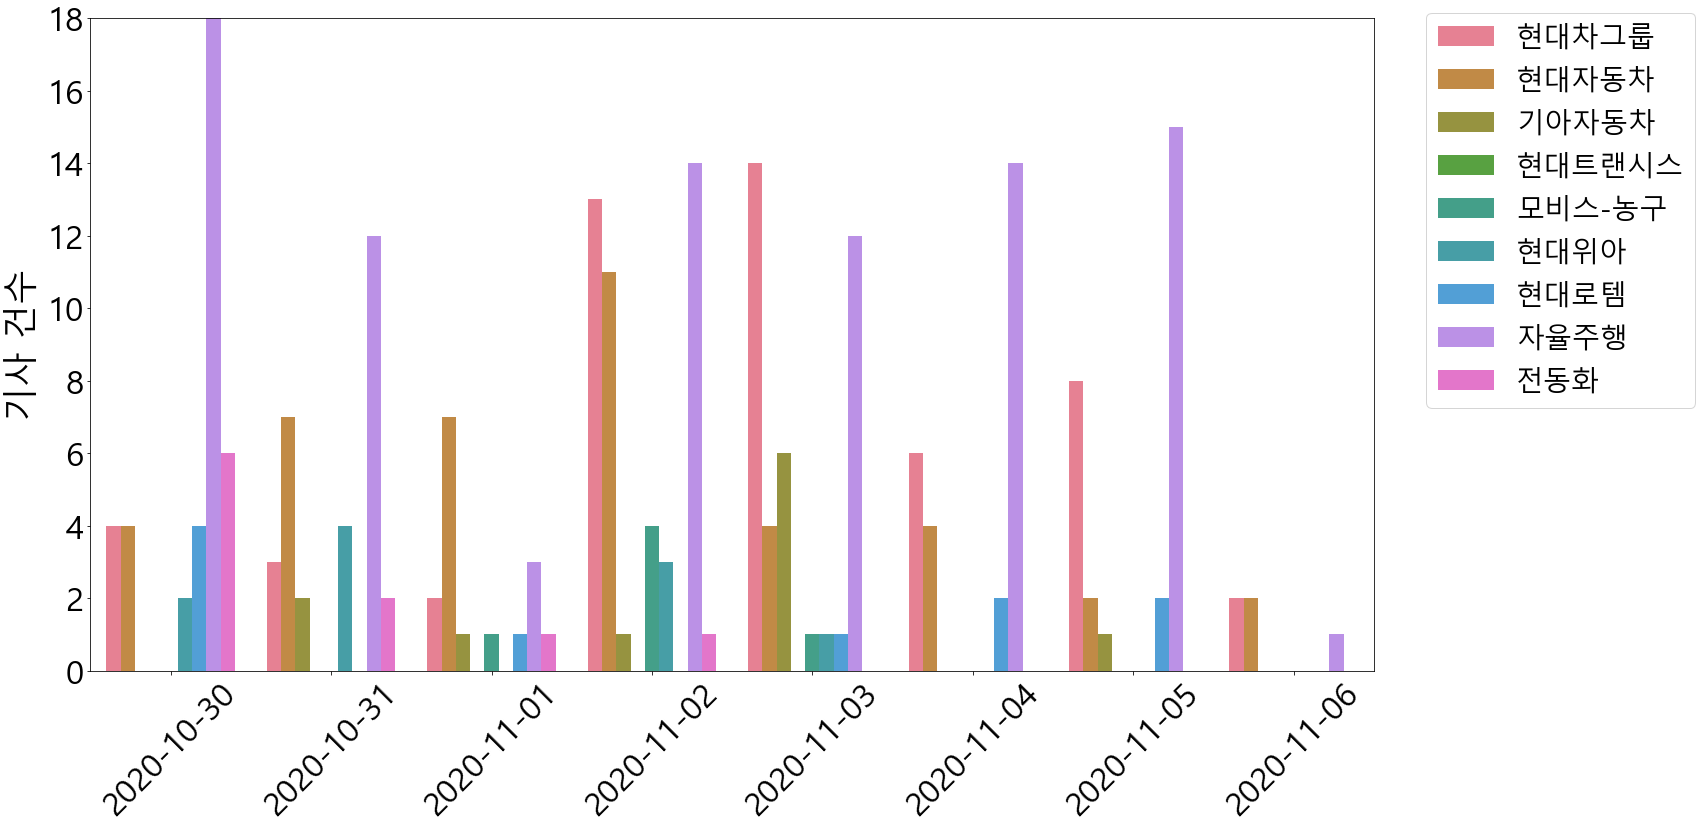

In [62]:
plt.figure(figsize=(23,12))
ax=sns.countplot(x="ymd", hue='keyword',data=test, palette='husl', order= ymd_list, hue_order=keywords)
ax.tick_params(labelsize=33)
# plt.title(" 미세먼지 8단계 분류 COUNT",size=25)
plt.legend(fontsize=28, bbox_to_anchor=(1.03, 1.03))
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('기사 건수', fontsize=35)
plt.ylim([0,18])
# plt.savefig(r'D:/pm/plot_count.png', format='png')
plt.show()

In [6]:
keywords = ['현대차그룹' ,'현대자동차', '기아자동차' , '현대트랜시스','모비스-농구','현대위아',
                   '현대로템','자율주행','전동화']
set_list = ['hmg','hyundai','kia','transys','mobis','wia','rotem','auto','elec']
for k,i in zip(set_list,keywords) :
    globals()[f'{k}']= df[df['keyword']==i]

검색어의 경우 기존의 재경본부에서 진행하는 현대차그룹, 현대자동차, 기아자동차, 현대트랜시스 네 가지의 검색어를 동일하게 진행하였습니다.
검색어를 선정해서 크롤링을 진행할 수 있게 작성하였고, 다른 검색어가 들어갈 경우 ERROR 코드로  
검색어 input data 가 입력값을 벗어났습니다. 다시 입력해주세요.문구가 뜨게 작성하였습니다

## TEST

In [ ]:
category = []
defalut_category = ['현대차그룹' ,'현대자동차', '기아자동차' , '현대트랜시스','모비스-농구','현대위아',
                   '현대로템','자율주행','자동차'] # 검색어 범주 지정
def select_keyword():
    while True:
        search_keywords = input("""
        크롤링 할 수 있는 검색어는 다음과 같습니다.
        ------------------------------------------------------------
        '현대차그룹' , '현대자동차', '기아자동차' , '현대트랜시스', '모비스-농구', '현대위아', '현대로템'
        '자율주행', '전동화'
        ------------------------------------------------------------
        크롤링 할 분야를 최소 한가지 이상 선택하여 입력해 주세요. 띄어쓰기로 구분합니다.
        입력:""")

        input_keyword = search_keywords.split()
        is_keyword = True
        for input_data in input_keyword:
            if not input_data in defalut_category:
                print('검색어' +input_data + " 가 입력값을 벗어났습니다. 다시 입력해주세요.")
                is_keyword = False
                break
        if is_keyword is True:
            break
        
    category.extend(input_keyword)
    return input_keyword

In [11]:
category = []
def select_date():
    while True:
        start_date = input("""
        검색 시작 날짜를 설정해주세요.
        --------------------------------------------------------------------------------
        데이터의 형식은 yyyy.mm.dd 형식으로 입력해주세요 (ex) 2020.11.02
        --------------------------------------------------------------------------------
        입력:""")
        is_date = True
        if bool(re.search(r'\d{3,4}.\d{1,2}.\d{2}',start_date)) == False :
            print('날짜' +input_data + " 가 입력값을 벗어났습니다. 다시 입력해주세요.")
            is_date = False
        
        if is_date is True:
            break
            
    while True:
        
        end_date = input("""
        검색 종료 날짜를 설정해주세요.
        --------------------------------------------------------------------------------
        데이터의 형식은 yyyy.mm.dd 형식으로 입력해주세요 (ex) 2020.11.02
        --------------------------------------------------------------------------------
        입력:""")
        
        is_date = True
        if bool(re.search(r'\d{3,4}.\d{1,2}.\d{2}',start_date)) == False :
            print('날짜' +input_data + " 가 입력값을 벗어났습니다. 다시 입력해주세요.")
            is_date = False
        
        if is_date is True:
            break
    
    return start_date, end_date

In [12]:
select_date()


        검색 시작 날짜를 설정해주세요.
        --------------------------------------------------------------------------------
        데이터의 형식은 yyyy.mm.dd 형식으로 입력해주세요 (ex) 2020.11.02
        --------------------------------------------------------------------------------
        입력:2020.11.01

        검색 종료 날짜를 설정해주세요.
        --------------------------------------------------------------------------------
        데이터의 형식은 yyyy.mm.dd 형식으로 입력해주세요 (ex) 2020.11.02
        --------------------------------------------------------------------------------
        입력:2020.11.06


('2020.11.01', '2020.11.06')

In [ ]:
title_list =[] # 제목을 저장하기 위한 list
url_list = [] # URL을 저장하기 위한 list
summary_list = [] # 날짜를 저장하기 위한 list

def Crawl(data):
    keywords = select_keyword()
    for keyword in keywords:
        page = f'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={keyword}'
        res = requests.get(page, headers={'User-Agent':
                                  ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                                   "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36")},
                   verify = False) 
        news_html = BeautifulSoup(res.text,'html.parser')
        
        content = news_html.select(".type01") # 기사 본문 저장되어 있는 html주소 복사


        title_content = content[0].select('dt > a') # 기사가 저장되어 있는 링크 추출

        for i in title_content :
            title_list.append(i.attrs['title'])


        url_content = content[0].select('dt > a')
        for i in url_content :
            url_list.append(i.attrs['href'])


        summary_content = content[0].select('dl > dd')
        for k in summary_content :
            if str(k.attrs) == "{'class': ['txt_inline']}" :
                continue

            for target in k.find_all('span'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
                target.extract()

            for target in k.find_all('ul'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
                target.extract()

            for target in k.find_all('div'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
                target.extract()

            k = k.get_text().strip()

            if not k  :
                continue
            summary_list.append(k)

In [ ]:
def date_preprocessing(soup, date_class) :
    date = soup.find_all("span",{"class":bar})
    # 날짜가 기록된 태그 저장
    start_date = datetime.now() # 현재 날짜 저장

    for j in date :
        date_list = j.get_text() #날짜 추출

        if '시간' in date_list : # 날짜가 n시간 전으로 표기될 경우 문자열 처리
            date_find = re.findall(r'\d+', date_list) 
            final_date = str(datetime.now() - timedelta(hours=int(date_find[0])))
            total_date.append(final_date)

        elif '분' in date_list : # 날짜가 n분 전으로 표기될 경우 문자열 처리
            date_find = re.findall(r'\d+', date_list)
            final_date = str(datetime.now() - timedelta(minutes=int(date_find[0])))
            total_date.append(final_date)

        elif '일' in date_list: # 날짜가 n일 전으로 표기될 경우 문자열 처리
            date_find = re.findall(r'\d+', date_list)
            final_date = str(datetime.now() - timedelta(days=int(date_find[0])))
            total_date.append(final_date)    

        elif bool(re.search(r'\d{3,4}.\d{1,2}.\d{2}',date_list)) == True : # yyyy.mm.dd로 표기될 경우 처리
            final_date = date_list.replace('.',"-")
            total_date.append(final_date)